# A Deep Dive Into Beer
---
### By Akshay Bhaskar, Sahil Hasan, Aniruddh Mohan
---
Craft beers have had an increase in popularity in recent times and we want to figure out what features of these craft beers have people hooked! 

We begin by first collecting valuable beer data from various sources such as Beeradvocate, OpenBreweryDB, and BreweryDB. 

Then, we use multivariate linear regression to try to predict beer ratings using beer features such as alcohol by volume, bitterness, if the beer is organic, etc. To obtain better model performance, we do feature selection to only retain the useful features that can predict beer ratings meaningfully and build a multivariate linear regression model on these features. Doing all this gives us a good sense into what attributes make for highly rated beers! Using our awesome model, can we build the perfect beer?

After exploring what goes into making a great beer great, we then use text reviews of beers to create a tfidf feature to understand what words are best associated with what beer type. We dig further into this by exploring which beers are more similar to each other and plot a correlation matrix. Now, because we're beer enthusiasts, we take this a step further (for personal gain of course!) by identifying beer simlarities for the top 50 beers in the world (many of which are American!) This helps us, and you, better decide which beers we want to drink next. Cheers!

Our curiosity seems to be leading us to all the wrong places. We use clustering to group various beer styles together. We then wonder, can we predict the beer style using only its text review? We do this by using a nearest neighbor classifier. 

Finally, we plot some very interactive maps showing the average beer rating by country across the world, and a map of breweries colored by brewery type across the United States.

In [0]:
from bs4 import BeautifulSoup
import collections
from collections import Counter
import csv
import folium
from folium.plugins import MarkerCluster
import iso3166
import json
import matplotlib.pyplot as plt
import numpy as np
import openbrewerydb
import pandas as pd
import plotly.graph_objects as go
import requests
import re
import seaborn as sns
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction import text 
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import fcluster
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split 
from sklearn import neighbors, datasets
import string
from string import digits

In [0]:
import warnings
warnings.filterwarnings('ignore')

# Scraping Data
---
After importing everything we need, we will scrape our data from three major sources. The first, as is loaded via a python library here, is from [OpenBreweryDB](https://www.openbrewerydb.org/) which provides a free public API for information about breweries in the United States. This data set requires no cleaning, and has a nice API, which allows us to very quickly access the data

In [0]:
def load_openbrew():
  #load up breweries, this takes a few minutes to run
  data = openbrewerydb.load()
  return data

In [4]:
openbrew_df = load_openbrew()
openbrew_df.head()

,id,name,brewery_type,street,city,state,postal_code,country,longitude,latitude,phone,website_url,updated_at,tag_list
0,2,Avondale Brewing Co,micro,201 41st St S,Birmingham,Alabama,35222-1932,United States,-86.774322,33.524521,2057775456,http://www.avondalebrewing.com,2018-08-23T23:19:57.825Z,[]
1,44,Trim Tab Brewing,micro,2721 5th Ave S,Birmingham,Alabama,35233-3401,United States,-86.791400,33.512849,2057030536,http://www.trimtabbrewing.com,2018-08-23T23:20:31.423Z,[]
2,46,Yellowhammer Brewery,micro,2600 Clinton Ave W,Huntsville,Alabama,35805-3046,United States,-86.593201,34.727752,2569755950,http://www.yellowhammerbrewery.com,2018-08-23T23:20:33.102Z,[]
3,55,Bearpaw River Brewing Co,micro,4605 E Palmer Wasilla Hwy,Wasilla,Alaska,99654-7679,United States,-149.412710,61.575269,,http://bearpawriverbrewing.com,2018-08-23T23:20:40.743Z,[]
4,76,King Street Brewing Co,micro,9050 King Street,Anchorage,Alaska,99515,United States,-149.879076,61.138489,9073365464,http://www.kingstreetbrewing.com,2018-08-23T23:20:57.179Z,[]


Our next major source is from [BeerAdvocate](https://www.beeradvocate.com/), an online beer rating forum that provides in-depth reviews and ratings of beers across the world. Since BeerAdvocate does not have an API, we wrote custom scrapers that access the data by iterating through various links of interest. This is done on a page by page basis, where we solely retain the information contained in certain tags that always contain the information we need. In particular, we get the top 250 beers by country for all the countries that BeerAdvocate tracks! These scrapers are not actually used in the static execution of this notebook as they take hours to fully run, so we will import a pre-formatted CSV of this data later on in our exploration. The CSV saving code is commented out in this cell.

In [0]:
def load_ba_top_country(country='at'):
  #create url for each country, and parse accordingly
  url = "https://www.beeradvocate.com/beer/top-rated/" + country + '/'
  soup = BeautifulSoup(requests.get(url).text)
  best_beers = soup.findAll('tr')
  data = []
  for i in range(1, len(best_beers)):
    row = best_beers[i].findAll('td')
    data_row = []
    link = best_beers[i].findAll('a', href=True)[0]['href']
    for j in range(len(row)):
      if not (j == 0) and not (j == 4):
        data_row.append(row[j].get_text(separator='|'))
    data_row.append(country)
    data_row.append('https://www.beeradvocate.com' + link)
    data.append(data_row)
  return pd.DataFrame(data, columns=["text", "num_ratings", "avg_rating", "country", "links"])

def load_ba_top():
  #takes a while to run as well
  total = []
  #iterate through all country codes and then get the top by country in one dataframe
  for c in iso3166.countries_by_alpha2:
      total.append(load_ba_top_country(country=c.lower()))
  return pd.concat(total)
  
def process_ba_top_data(df):
  new = df.text.str.split('|', expand = True)
  df['drink_name'] = new[0]
  df['brewery'] = new[1]
  df['drink_type'] = new[2]
  df['abv'] = new[4].str.rstrip('%').astype(float)
  out = df.drop(columns =["text"])
  return out

def get_links(names):
  reg_tag = re.compile("/beer/profile/\d+/\d+/")
  out = []
  def get_url(name):
      req = requests.get('https://www.beeradvocate.com/search/?q='+ name.lower() +'&qt=beer')
      soup = BeautifulSoup(req.text, 'html.parser')
      tags = soup.findAll('a' , attrs={'href': reg_tag})
      for link in tags:
          return 'https://www.beeradvocate.com' + link.get('href')
      return None
  for n in names:
    tmp = get_url(n)
    out.append(tmp)
  return out

def get_rating(links):
  out = []
  for l in links:
    if l is not None:
      req = requests.get(l)
      soup = BeautifulSoup(req.text, 'html.parser')
      out.append(float(soup.findAll('span', {'class': 'ba-ravg Tooltip'})[0].text))
    else:
      out.append(None)
  return out

def get_reviews(links):
  out = []
  for l in links:
    if l is not None:
       req = requests.get(l)
       soup = BeautifulSoup(req.text, 'html.parser')
       row = []
       total = 0
       for t in soup.findAll('div', {'id': 'rating_fullview_content_2'}):
         tmp = re.sub("overall: [0-9].?[0-9]+", "", t.text.split('|')[-1], count=1)
         tmp = re.sub("overall: [0-9]", "", tmp, count=1)
         if total > 4000:
           break
         total += len(tmp)
         row.append(tmp)
       if total > 1000:
         out.append(row)
       else:
         out.append(None)
  return out

## CSV Saving code is commented out ##
# import pickle
# reviews = get_reviews(list(clean_ba_df.links))
# with open('reviews.pck', 'wb') as handle:
#     pickle.dump(reviews, handle)
# links = get_links(list(beers_set.name))
# print(links)
# ratings = get_rating(links)
# print(ratings)
# with open('ratings.pck', 'wb') as handle:
#     pickle.dump(ratings, handle)
# beers_set['ratings'] = ratings
# beers_set.to_csv('beers_set.csv')
# str_revs = [str(s) for s in reviews]
# clean_ba_df['reviews'] = str_revs
# clean_ba_df.to_csv('clean_ba_df.csv')

Our final source of data is [BreweryDB](https://www.brewerydb.com/), which provides extensive amounts of information about individual beers, with features such as ABV (Alcohol By Volume) and IBU (International Biterness Unit) that will allow us to run linear regression. We do this by combining this data with the ratings scraped from BeerAdvocate above.

In [0]:
def beerdata():
  url = "https://sandbox-api.brewerydb.com/v2/beers/?key=ff48dc71c860b607d027eb706155aa47"
  r1= requests.get(url)
  d = json.loads(r1.content)
  pages = d['numberOfPages']
  data1=[]
  for i in range(pages):
    params = {'p':i}
    r1= requests.get(url, params=params)
    d1 = json.loads(r1.content)
    data1.append(d1['data'])   
  
  ###this will take 10-15 seconds to run 
  beers=[]
  ####iterating over each inner list which is each page, and then iterating over the list of 50 dictionaries which is the actual beers
  for i in range(len(data1)):
    for j in range(len(data1[i])):
      beer = data1[i][j].copy()
      if 'style' in data1[i][j].keys():
        b1 = beer['style'].copy() #for unrolling as style itself is a dict
        b1.pop('category', None)
        b1.pop('createDate',None)
        b1.pop('shortName',None)
        b1['type_description'] = b1.pop('description')
        b1['style_name'] = b1.pop('name')
      else:
        b1 = {}
      keysToRemove = ('labels','available','availableId','createDate', 'isRetired','nameDisplay','updateDate','year','status','statusDisplay','style','glass','updateDate')
      for k in keysToRemove:
        beer.pop(k, None)
      a1 = {j:k for j,k in beer.items()}
      a1.update(b1)
      beers.append(a1)       
  return pd.DataFrame(beers)

In [6]:
beers_set = beerdata()
cols_delete = ['servingTemperatureDisplay', 'originalGravity', 'servingTemperature', 'updateDate', 'srmId', 'srm', 'ogMax', 'glasswareId', 'foodPairings']
for col in cols_delete:
  del beers_set[col]
beers_set.head()

,id,name,abv,styleId,isOrganic,categoryId,ibuMin,ibuMax,abvMin,abvMax,srmMin,srmMax,ogMin,fgMin,fgMax,type_description,style_name,description,ibu
0,98,'Murican Pilsner,5.5,98.0,N,8.0,25,40,5,6,3,6,1.045,1.012,1.018,This classic and unique pre-Prohibition Americ...,American-Style Pilsener,NaN,NaN
1,164,11.5° PLATO,4.5,164.0,N,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Session India Pale Ales are gold to copper. Ch...,Session India Pale Ale,The Plato scale is a measurement of the densit...,35
2,25,12th Of Never,5.5,25.0,N,3.0,30,42,4.5,5.6,6,14,1.044,1.008,1.014,American pale ales range from deep golden to c...,American-Style Pale Ale,"Tropically Hoppy. Light, yet Full-Bodied. Brig...",45
3,5,15th Anniversary Ale,NaN,5.0,N,1.0,30,45,4.8,5.8,8,14,1.046,1.01,1.016,Extra special bitter possesses medium to stron...,Extra Special Bitter,For the ﬁrst ever SweetWater anniversary beer ...,NaN
4,35,16 So Fine Red Wheat Wine,11,35.0,N,3.0,45,85,8.4,12,8,15,1.088,1.024,1.032,American style wheat wines range from gold to ...,American-Style Wheat Wine Ale,For our super heady 16 year anniversary beer w...,NaN


Once again, since our data set takes a while to collect, we will load in our data via CSV. There is no functional difference between the two, this loading process is just done to save time.



# Linear Regression
--- 
Our first experiment is to see if we can predict the ratings of beers by their various features. In order to do this, we want to utilize linear regression on a subset of our features. Our first step is to load in our data and clean it up by removing columns that we do not need and removing rows that contain NaNs.

Our dataset contains many columns that aren't really useful for linear regression. We begin by first deleting these columns. Notice that the `isOrganic` column is Y/N. For linear regression, we convert this to 1/0. Finally, we drop the rows that have incomplete data i.e. drop rows with `NaN` values. 

Important column headers:

<br /> 
`abv` - alcohol by volume
<br /> 
`fg` - specific gravity of beer
<br /> 
`ibu` - international bitterness unit
<br /> 
`isOrganic` - whether beer is organic or not

In [0]:
dataset = pd.read_csv('beers_set.csv')
# delete columns we don't need for linear regression
del dataset['Unnamed: 0']
del dataset['description']
del dataset['name']
del dataset['style_name']
del dataset['type_description']
del dataset['categoryId']
del dataset['id']
del dataset['styleId']

# convert isOrganic string Y/N to int 1/0 for linear regression
dataset.isOrganic.replace(('Y', 'N'), (1, 0), inplace=True)

# drop rows with NaN
dataset = dataset.dropna(how='any')

Let's now visualize our dataset and see some statistics.

In [9]:
dataset.head()

,abv,abvMax,abvMin,fgMax,fgMin,ibu,ibuMax,ibuMin,isOrganic,ogMin,srmMax,srmMin,ratings
2,5.5,5.6,4.5,1.014,1.008,45.0,42.0,30.0,0,1.044,14.0,6.0,3.97
7,10.0,10.0,7.0,1.018,1.010,17.0,45.0,20.0,0,1.070,9.0,4.0,3.94
12,6.5,7.5,6.3,1.018,1.012,50.0,70.0,50.0,0,1.060,14.0,6.0,3.88
17,7.9,6.5,4.8,1.016,1.008,7.0,25.0,15.0,0,1.044,20.0,12.0,3.99
25,5.4,5.6,4.5,1.014,1.008,41.0,42.0,30.0,0,1.044,14.0,6.0,3.66


In [10]:
# see some stats for our dataset
dataset.describe()

,abv,abvMax,abvMin,fgMax,fgMin,ibu,ibuMax,ibuMin,isOrganic,ogMin,srmMax,srmMin,ratings
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,6.835581,7.573371,5.455382,1.018629,1.010890,44.232266,53.770538,33.796034,0.079320,1.054887,18.325779,10.830028,3.840057
std,2.007492,2.311637,1.444199,0.005494,0.004466,24.605807,25.175882,18.118872,0.270621,0.015102,11.700517,11.676973,0.316257
min,3.200000,3.400000,0.500000,1.006000,1.002000,0.000000,6.000000,3.000000,0.000000,1.008000,2.000000,2.000000,1.780000
25%,5.400000,5.600000,4.500000,1.016000,1.008000,25.000000,35.000000,20.000000,0.000000,1.044000,13.000000,4.000000,3.650000
50%,6.300000,7.500000,5.300000,1.018000,1.012000,40.000000,45.000000,30.000000,0.000000,1.050000,14.000000,6.000000,3.870000
75%,8.000000,8.800000,6.300000,1.020000,1.012000,60.000000,70.000000,50.000000,0.000000,1.060000,22.000000,11.000000,4.050000
max,20.000000,12.000000,8.400000,1.040000,1.024000,167.000000,100.000000,65.000000,1.000000,1.090000,50.000000,40.000000,4.550000


Before we move on to the actual linear regression and analysis, we should first see how the ratings are distributed in order to better understand our data. Below you will find a histogram of all ratings. 

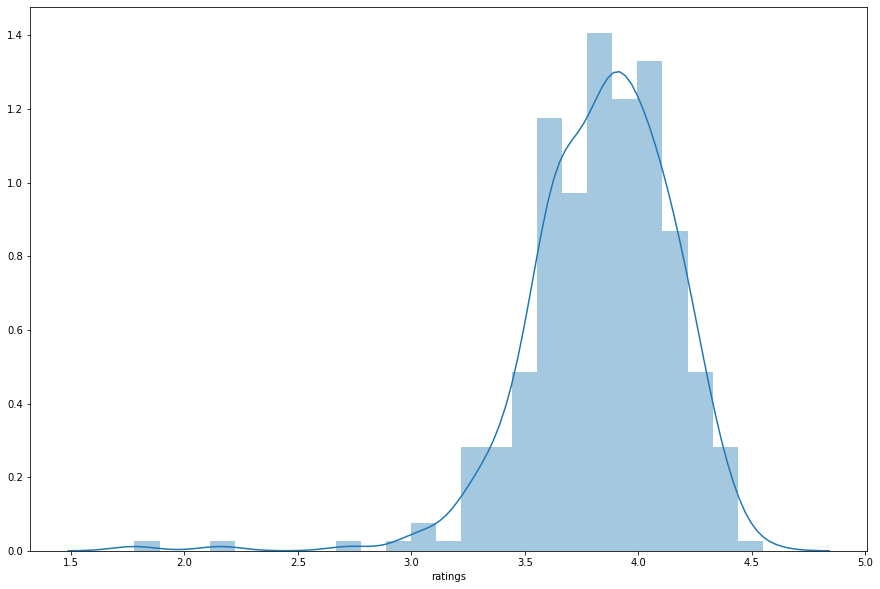

In [11]:
# histogram of beer ratings 
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.distplot(dataset['ratings'])

From the histogram above, we see that most ratings lie between 3.5 and 4.5 out of 5.0. This isn't very surprising as you'd expect most people to assign ratings in this range. Only in extreme circumstances would people give ratings like a 0 or 1.0 out of 5.0 e.g. if the beer was horrible! Interestingly, we also don't see any 5.0 ratings. In fact, if you take a look at the statistics table above, you see that the highest rating we have for a beer in our dataset is a 4.5, which is lower than expected.

Now that we understand the distribution of ratings, we can move on to linear regression. First, we are going to try to use the features of a beer to predict its rating. This requires us to divide our dataset into features and labels. For linear regression, we will use the `LinearRegression` model from `sklearn`. Notice that we are not normalizing our features here. This is becasue `LinearRegression` uses ordinary least squares. Ordinary least squares is invariant - for invariant methods there is no real need for standardization, whereas for non-invariant methods you probably do need to standardize or normalize your data. 

In [0]:
# divide dataset into attributes X and labels Y
X = dataset[['abv', 'abvMax', 'abvMin', 'fgMax', 'fgMin', 'ibu', 'ibuMax', 'ibuMin', 'isOrganic', 'ogMin', 'srmMax', 'srmMin']].values
y = dataset['ratings'].values

Now, we split our dataset into a training set (80%) and test set (20%). 

In [0]:
# split into train (80%) and test (20%) set
# set random_state if you want reproducible results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

From there, we can fit our train data to the `LinearRegression` model. Let's use our model to predict on the test set and see how our predicted values compare to the ground truth. 

In [14]:
# train model
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
# predict on test set
y_pred = regressor.predict(X_test)
# let's see some actual vs. predicted values
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df.head(10)

,Actual,Predicted
0,4.04,4.101464
1,4.13,4.055953
2,3.35,3.607601
3,3.51,3.742747
4,3.91,3.694872
5,4.22,4.096273
6,3.57,3.701637
7,3.75,3.994710
8,3.95,3.857280
9,3.72,3.804279


The chart below compares our predicted values (orange bars) to their ground truths (blue bars). The y-axis is the rating of a beer, and the x-axis represents each beer in our test set. While for some beers our model does a very good job at predicting its ratings, for the most part, our model doesn't do a great job at predicting beer ratings.

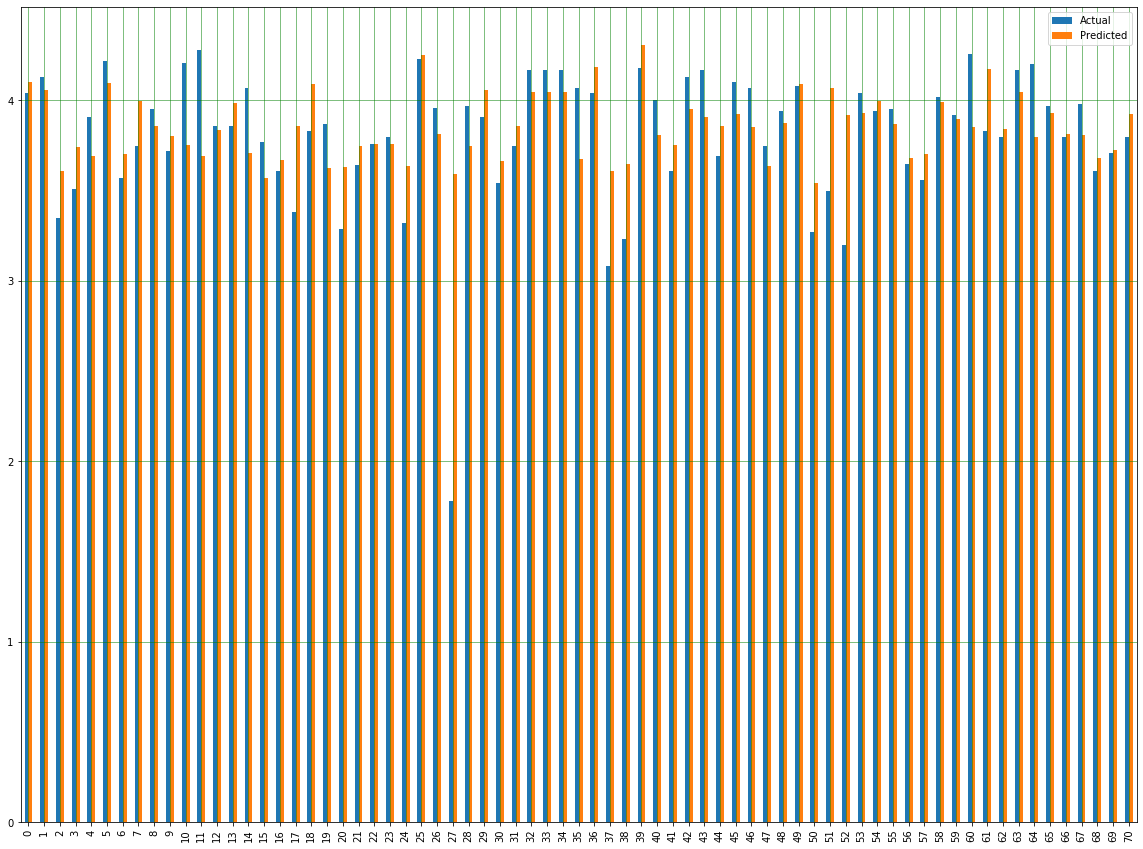

In [15]:
# plot comparison of actual vs. predicted values
df.plot(kind='bar',figsize=(20,15))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

This chart definitely provides an interesting visualization of how each of our predictions did in terms of accuracy, but does not provide a good overall picture. For that, let's analyze some of the metrics of our model.

In [16]:
# see performance metrics of our model
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

# the lower the value is, the better the fit
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

# the closer towards 1, the better the fit
print('R^2 score:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 0.21130907715896796
Mean Squared Error: 0.10518333452856723
Root Mean Squared Error: 0.3243198028621861
R^2 score: 0.2567243825019011


Initially, linear regression does an mediocre job at predicting beer ratings. We achieve an $R^2$ score of about 25%. This means that our model can only explain about 25% of the variability in beer ratings. This is far from ideal and clearly, we can improve. In order to improve, we will first visualize every feature against beer rating to visually identify any correlations and then try to only using these features to see if we can improve model performance. These plots are displayed three at a time below.

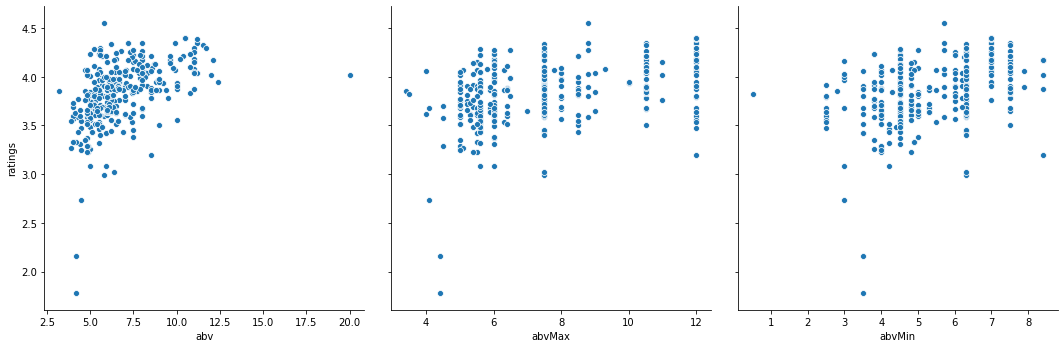

In [17]:
# visualize the relationship between the atributes/features and the label/target using scatterplots
sns.pairplot(dataset, x_vars=['abv', 'abvMax', 'abvMin'], y_vars='ratings', height=5)

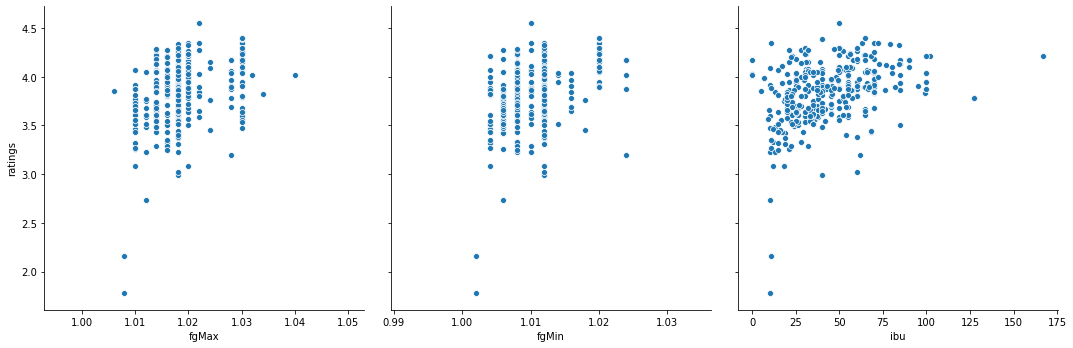

In [18]:
sns.pairplot(dataset, x_vars=['fgMax', 'fgMin', 'ibu'], y_vars='ratings', height=5)

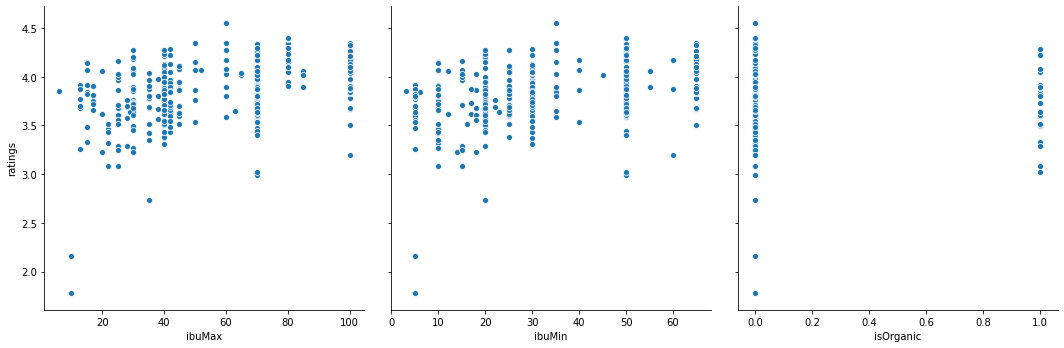

In [19]:
sns.pairplot(dataset, x_vars=['ibuMax', 'ibuMin', 'isOrganic'], y_vars='ratings', height=5)

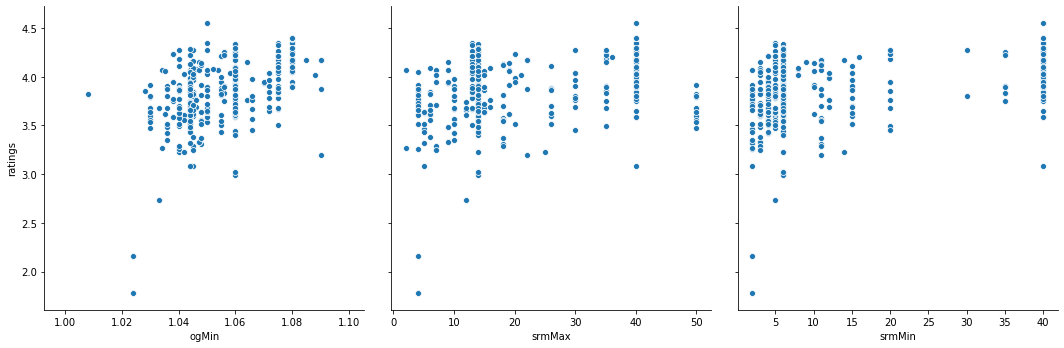

In [20]:
sns.pairplot(dataset, x_vars=['ogMin', 'srmMax', 'srmMin'], y_vars='ratings', height=5)

From the plots above, it is clear that `abv` and `ibu` have a heavy correlation with the rating of a beer. This intuitively makes sense as one would expect the rating of the beer to be influenced by both the alcohol by volume and its bitterness. To be sure, we will look at their `p scores`.

In [21]:
lm1 = smf.ols(formula='ratings ~ abv + abvMax + abvMin + fgMax + fgMin + ibu + ibuMax + ibuMin + isOrganic + ogMin + srmMax + srmMin', data=dataset).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ratings   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     14.33
Date:                Thu, 12 Dec 2019   Prob (F-statistic):           3.56e-24
Time:                        03:01:23   Log-Likelihood:                -21.777
No. Observations:                 353   AIC:                             69.55
Df Residuals:                     340   BIC:                             119.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0561      6.257      0.488      0.626      -9.251      15.363
abv            0.0371      0.011      3.419      0.001       0.016       0.058
abvMax        -0.0207      0.033     -0.623      0.533      -0.086       0.045
abvMin         0.0184      0.038      0.483      0.630      -0.056       0.093
fgMax         13.1777      7.685      1.715      0.087      -1.938      28.294
fgMin        -18.7259      8.797     -2.129      0.034     -36.029      -1.423
ibu            0.0034      0.001      3.741      0.000       0.002       0.005
ibuMax        -0.0022      0.004     -0.562      0.575      -0.010       0.006
ibuMin         0.0019      0.005      0.376      0.707      -0.008       0.012
isOrganic     -0.0220      0.053     -0.411      0.682      -0.127       0.083
ogMin          5.6001      4.803      1.166      0.244      -3.848      15.048
srmMax         0.0025      0.004      0.688      0.492      -0.005       0.009
srmMin         0.0045      0.003      1.580      0.115      -0.001       0.010
==============================================================================
Omnibus:                      132.569   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              815.307
Skew:                          -1.438   Prob(JB):                    9.09e-178
Kurtosis:                       9.867   Cond. No.                     6.83e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.83e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Without getting into complex analysis, from the above table we can see that `abv` and `ibu` have low `p` values (< 0.05). This indicates that you can reject the null hypothesis. In other words, a predictor that has a low p-value is likely to be a meaningful addition to your model because changes in the predictor's value are related to changes in the response variable. So now, we're confident that `abv` and `ibu` are features that definitively influence beer ratings. The other features have high `p` values which indicate that they are poorly associated with the response variable, which in our case are the beer ratings.

Follwing that analysis, we will now build a linear regression model with only the `abv` and `ibu` features. First, we will remove all of the features that have high `p` values. Then, for `abv` and `ibu` features, we will also ignore outliers. As we know, outliers can significantly influence a linear regression model, which can have far reaching issues with our model's performance. Once that is done, we can build a new linear regression model just like we did above.

In [22]:
# work with only abv and ibu data & get rid of outliers
abv_ibu_data = dataset[(dataset.ibu < 110) & (dataset.abv < 13) & (dataset.ratings > 3.25)]

del abv_ibu_data['abvMax']
del abv_ibu_data['abvMin']
del abv_ibu_data['fgMax']
del abv_ibu_data['fgMin']
del abv_ibu_data['ibuMax']
del abv_ibu_data['ibuMin']
del abv_ibu_data['isOrganic']
del abv_ibu_data['ogMin']
del abv_ibu_data['srmMax']
del abv_ibu_data['srmMin']

abv_ibu_data.head()

,abv,ibu,ratings
2,5.5,45.0,3.97
7,10.0,17.0,3.94
12,6.5,50.0,3.88
17,7.9,7.0,3.99
25,5.4,41.0,3.66


In [23]:
# divide dataset into attributes X and labels Y
X = abv_ibu_data[['abv', 'ibu']].values
y = abv_ibu_data['ratings'].values
# split into train (80%) and test (20%) set
# set random_state if you want reproducible results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# train model
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
# predict on test set
y_pred = regressor.predict(X_test)
# let's see some actual vs. predicted values
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df.head(10)

,Actual,Predicted
0,3.70,3.808118
1,4.15,4.103411
2,3.64,3.808118
3,4.04,4.031320
4,3.77,3.665394
5,3.80,3.736501
6,3.94,4.001082
7,4.27,3.859919
8,3.70,3.819524
9,3.72,3.823156


Similar to the chart previously, the chart below compares our predicted values (orange bars) to their ground truths (blue bars). The y-axis is the rating of a beer, and the x-axis represents each beer in our test set. Compared to the previous model, our model now does a much better job at predicting beer ratings.

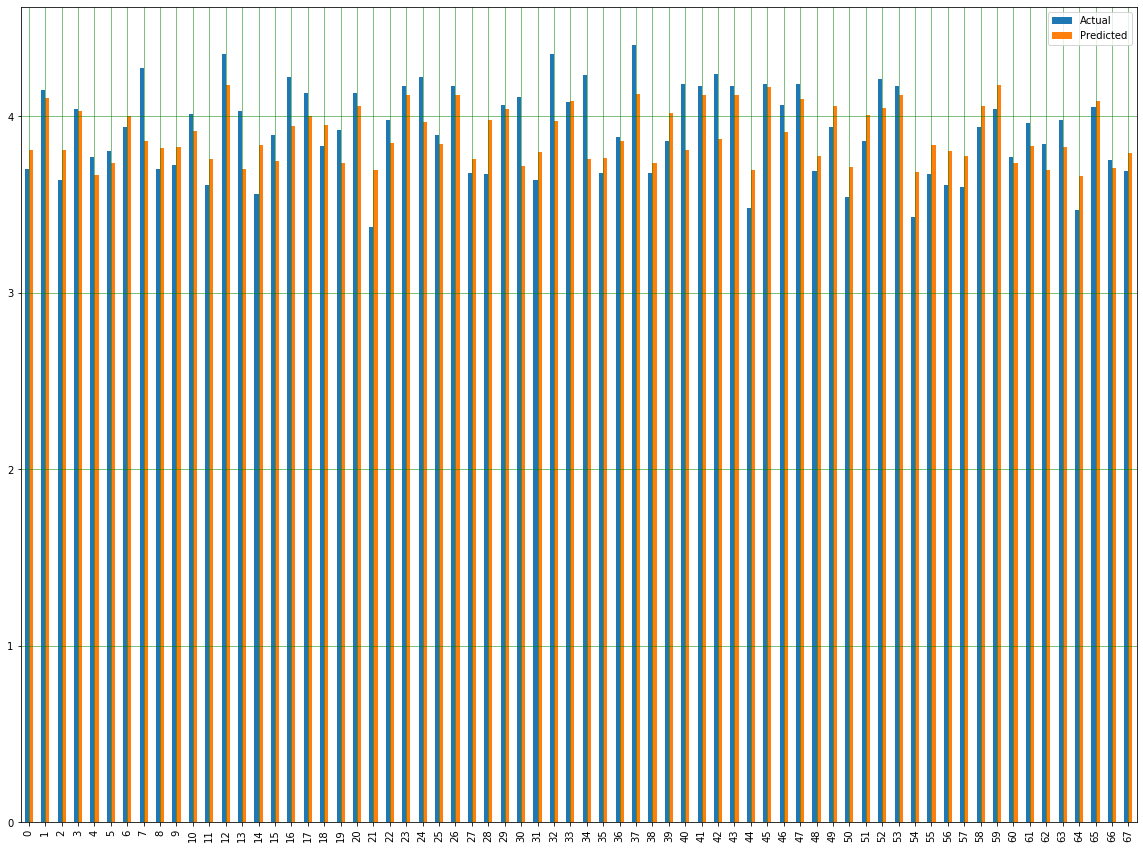

In [24]:
# plot comparison of actual vs. predicted values
df.plot(kind='bar',figsize=(20,15))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [25]:
# see performance metrics of our model
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

# the lower the value is, the better the fit
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

# the closer towards 1, the better the fit
print('R^2 score:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 0.15187662707830477
Mean Squared Error: 0.03503450494626649
Root Mean Squared Error: 0.18717506496931285
R^2 score: 0.4505688633407122


Here, we see the Root Mean Square Error (RMSE) significantly improves from the previous model. The $R^2$ score also improves significantly - our model can now explain about 45% of the variability in beer ratings, which is still nowhere near perfect, but shows drastic improvement from our initially naive solution.

We've now got some interesting results. This is practical evidence that feature selection is crucially important when building linear regression models. Often times, you will have many features that don't really add value to your model and in some cases, like ours, it can even hinder your model. 

In conclusion, while we made good progress from the first model to the second, we still can't say with enough confidence that linear regression does a good job at predicting beer ratings from the data we have. Intuitively, this makes sense, as one can imagine how hard it might be to predict the rating of a beer, as human nature is relatively fickle. This is increasingly difficult when faced with numerical data such as alcohol by volume and bitterness.

---
Before we are ready to start analyzing various beer reviews, we need to load in the data via a CSV file. Here, we load in our pre-downloaded data set scraped from BeerAdvocate. We provide a preview of the data below

In [26]:
def load_ba_from_csv():
  return pd.read_csv('clean_ba_df.csv')

dataset = load_ba_from_csv()
dataset.head()

,Unnamed: 0,num_ratings,avg_rating,country,links,drink_name,brewery,drink_type,abv,reviews
0,0,40,3.43,al,https://www.beeradvocate.com/beer/profile/1722...,Korça Bjonde,Birra Korça,European Pale Lager,4.1,[' Gold in color with a fingernail of eggshell...
1,1,33,2.90,al,https://www.beeradvocate.com/beer/profile/2907...,Birra Tirana,Birra Tirana,European Pale Lager,4.0,[' oz bottle thanks to Jeremy. Typical euro p...
2,0,47,2.93,ag,https://www.beeradvocate.com/beer/profile/842/...,Wadadli,Antigua Brewery Ltd.,American Adjunct Lager,4.8,[' A 250ml bottle brought back from Antigua by...
3,0,25,3.72,ar,https://www.beeradvocate.com/beer/profile/1111...,Imperial Stout,Antares,Russian Imperial Stout,8.5,"["" Bold in character, rich with flare and dang..."
4,1,30,3.72,ar,https://www.beeradvocate.com/beer/profile/1518...,Cerveza Jerome Negra,Cerveza Jerome,English Sweet / Milk Stout,6.5,"["" ounce bottle (labeled Andean Stout). Serve..."


#Analyzing Reviews
---

As we can see the text is not fully ready for analysis. Our next step is to pre-process our text data in the reviews column. This mainly involves converting all text to lower case, stripping out punctuation and digits, and splitting the text into words. Splitting text into words will be incredibly useful later, as we will group by beer type. Additionally, we also gather word counts in order to get the distribution of words across our entire text data. This will be useful in our later explorations to aid in filtering out noise.

In [27]:
list2 = []
cnt=Counter()
for item in dataset['reviews']:
    item1 = item.strip('[')    
    item2 = item1.strip(']')
    item3 = item2.lower()
    item4 = item3.translate(str.maketrans('', '', string.punctuation))
    remove_digits = str.maketrans('', '', digits)
    res = item4.translate(remove_digits)
    item5 = res.split()     #doing this because for some reason python is treating the entire string as one word instead of a collection of words
    for word in item5:
        cnt[word] += 1
    list2.append(item5)
dataset['reviews'] = list2
dataset.head()

,Unnamed: 0,num_ratings,avg_rating,country,links,drink_name,brewery,drink_type,abv,reviews
0,0,40,3.43,al,https://www.beeradvocate.com/beer/profile/1722...,Korça Bjonde,Birra Korça,European Pale Lager,4.1,"[gold, in, color, with, a, fingernail, of, egg..."
1,1,33,2.90,al,https://www.beeradvocate.com/beer/profile/2907...,Birra Tirana,Birra Tirana,European Pale Lager,4.0,"[oz, bottle, thanks, to, jeremy, typical, euro..."
2,0,47,2.93,ag,https://www.beeradvocate.com/beer/profile/842/...,Wadadli,Antigua Brewery Ltd.,American Adjunct Lager,4.8,"[a, ml, bottle, brought, back, from, antigua, ..."
3,0,25,3.72,ar,https://www.beeradvocate.com/beer/profile/1111...,Imperial Stout,Antares,Russian Imperial Stout,8.5,"[bold, in, character, rich, with, flare, and, ..."
4,1,30,3.72,ar,https://www.beeradvocate.com/beer/profile/1518...,Cerveza Jerome Negra,Cerveza Jerome,English Sweet / Milk Stout,6.5,"[ounce, bottle, labeled, andean, stout, served..."


Our dataset is now ready, as our reviews are a collection of words. We have not yet however filtered out stopwords and incorrect words from our text. We also will group the beers by our variable of interest, beer type (the `drink_type` column). We do both of these steps below. We also filter our some additional words that are not representative of the characteristics of a beer but are instead generic adjectives like good, great, nice as well as generic beer words like hop, glass, beer, etc.

In [28]:
def get_rare_words(dist):    #Used this function from our homework where we did text analysis
    """use the word count information from the training data to find more stopwords

    args:
        dist: collections.Counter -- the cnt variable we created above

    returns : Set[str] -- a set of all words that appear less than or equal to 10 times in the training data
    """
    a = dict(dist)
    b = {k:v for (k,v) in a.items() if v<=10}
    c = set(b.keys())
    return c

stopwords_new = get_rare_words(cnt)

#define some other stopwords based on the specific data we are handling like beer, lager, hop, glass etc. as well 
# as some adjectives like good, nice, great which appear a lot.

other_stopwords = set(['beer', 'hop', 'beers', 'glass', 'head', 'good', 'like', 'ipa', 'body', 
                      'pretty', 'smells', 'smell', 'hops', 'alcohol', 'taste', 'lager', 'bit', 'light', 'malt', 
                      'dark', 'white', 'ale', 'quite', 'nice', 'bottle', 'pale', 'carbonation', 'bitterness', 
                      'just', 'little', 'really', 'lots', 'notes', 'ales', 'smoked', 'smokey', 'smoky', 'malts'])
stopwords_new = stopwords_new.union(other_stopwords)    #full list of stopwords

##group by drink type and aggregate all reviews
grp1 = dataset.groupby('drink_type', as_index=False).agg({'reviews':lambda x: list(x)})
list3=[]
for item in grp1['reviews']:
    item1 = sum(item, [])
    item2 = [w for w in item1 if not w in stopwords_new]
    item3 = [w for w in item2 if not w.startswith('character')]    #remove usernames which all begin with character
    item4 = " ".join(item3)
    list3.append(item4)
grp1['reviews'] = list3
grp1.head()

,drink_type,reviews
0,American Adjunct Lager,a ml brought back from by friends although it ...
1,American Amber / Red Ale,a the is clear red in color and has a amount o...
2,American Amber / Red Lager,bright amber lively thin yet lasting foamy the...
3,American Barleywine,medium to amber in color with a high degree of...
4,American Black Ale,pitch black with no visible only a hint of a c...


We are now ready! Our first step is to create a tf-idf feature for our reviews all of them grouped by the beer type!


Now, we can visualise the results. What are the most common words consumers use to describe each beer type? Can we see the most characteristic words for each style? For example, are Stouts defined by the flavor "coffee" while IPAs generally have a "citrus" feel?

Do reviewers talk different about Pilsners than Lagers?

We use the tf-idf scores to see this! Term Frequency-Inverse Document Frequency, or tf-idf, is a statistic used to identify keywords in each document by normalizing the word by the amount of times it appears in all documents. In essence it looks for words that are more frequent in a document but rare in all other documents. Those words are then good indicators of the contents of that document, and be often times used to somewhat define the underlying document.


In [0]:
vectorizer = TfidfVectorizer(stop_words='english', max_features = 10000)
X = vectorizer.fit_transform(grp1['reviews'])
ind1 = []
X = X.toarray()
terms2 = np.array(vectorizer.get_feature_names())
tfidfscorevalues=[]
for i in range(X.shape[0]):
    a1 = X[i,:].ravel().argsort()[-3:]  #where the 3 most common words for that beer are located
    tfidfscorevalues.append(X[i,:][a1])
    ind1.append(a1)    #where the 3 most common words is located

In [30]:
print("Top terms per beer type:")
print("="*50)
for i in range(0,10):
    beertype = grp1['drink_type'][i]
    print (beertype)
    print(terms2[ind1][i])
    print("_____________________________________________")

Top terms per beer type:
American Adjunct Lager
['sweet' 'adjunct' 'corn']
_____________________________________________
American Amber / Red Ale
['caramel' 'red' 'amber']
_____________________________________________
American Amber / Red Lager
['sweet' 'amber' 'caramel']
_____________________________________________
American Barleywine
['sweet' 'caramel' 'barleywine']
_____________________________________________
American Black Ale
['chocolate' 'coffee' 'black']
_____________________________________________
American Blonde Ale
['sweet' 'golden' 'blonde']
_____________________________________________
American Brett
['brettanomyces' 'brett' 'peat']
_____________________________________________
American Brown Ale
['caramel' 'sweet' 'brown']
_____________________________________________
American Cream Ale
['yellow' 'bogota' 'honey']
_____________________________________________
American Dark Wheat Ale
['got' 'buckwheat' 'funk']
_____________________________________________


We see that we have lots of interesting results. An even better way to see would be to plot out the top words for a few beers. Let's do this for a particular subset of 10 of the most common American beers. 

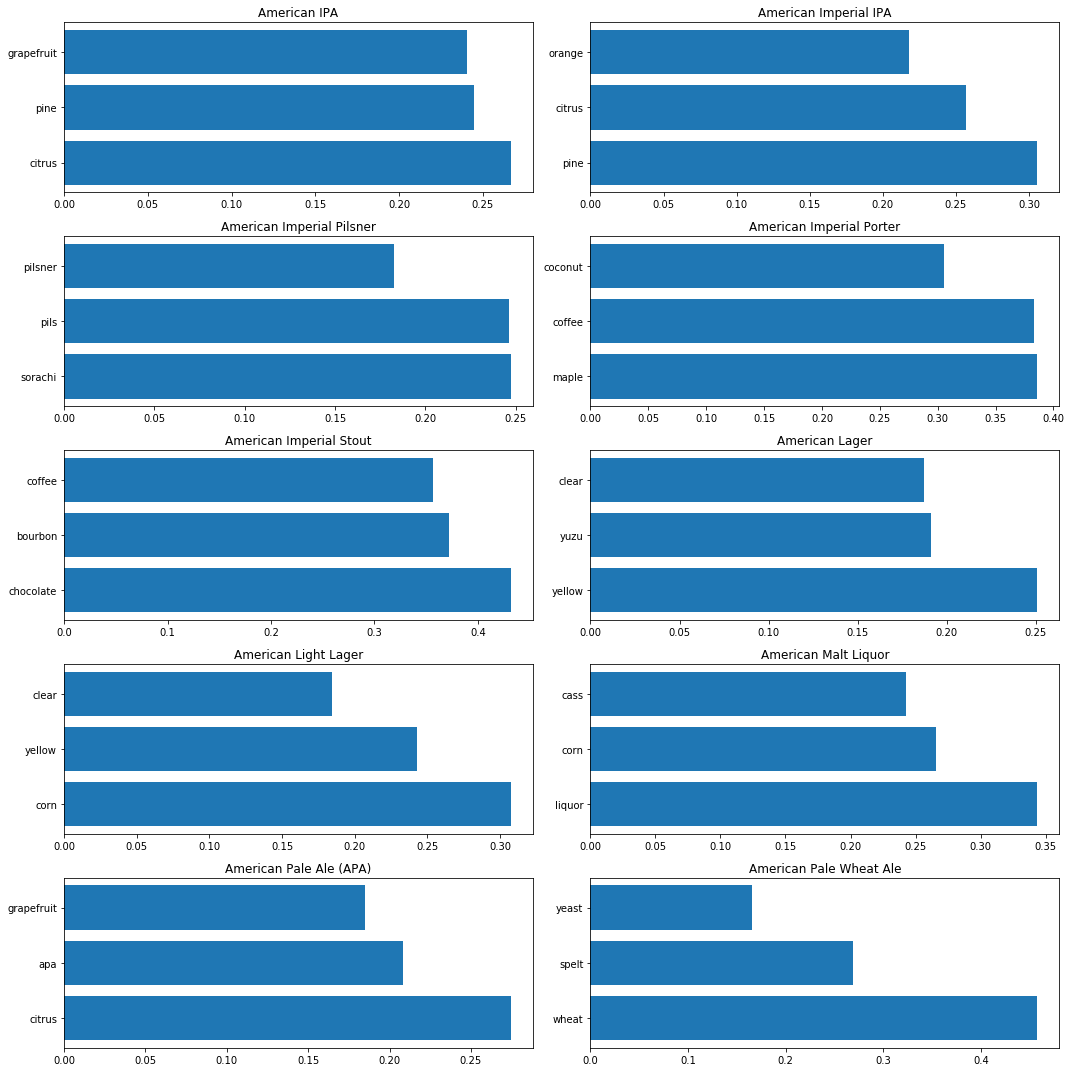

In [31]:
fig = plt.figure(figsize=(15, 15))
for i in range(10,20):
    ax = fig.add_subplot(5, 2, i-9)
    y_pos = np.arange(len(terms2[ind1][i]))
    ax.barh(y_pos, tfidfscorevalues[i], align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(terms2[ind1][i])
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_title(grp1['drink_type'][i])
plt.tight_layout()

Thats pretty cool right? We can now explore which beers are more similar to each other too, after all we have the key words and the tf-idf scores for each type of beer. Let's visualise this through a correlation matrix. First, we create the cosine similarity for x and then calculate it's correlation which essentially tells us how similar each row of our dataset (which in this case is each beer type) is to each other. We can then plot the correlation triange for the beers. We will only do this for a subset of our data to keep the size of the plot reasonable.



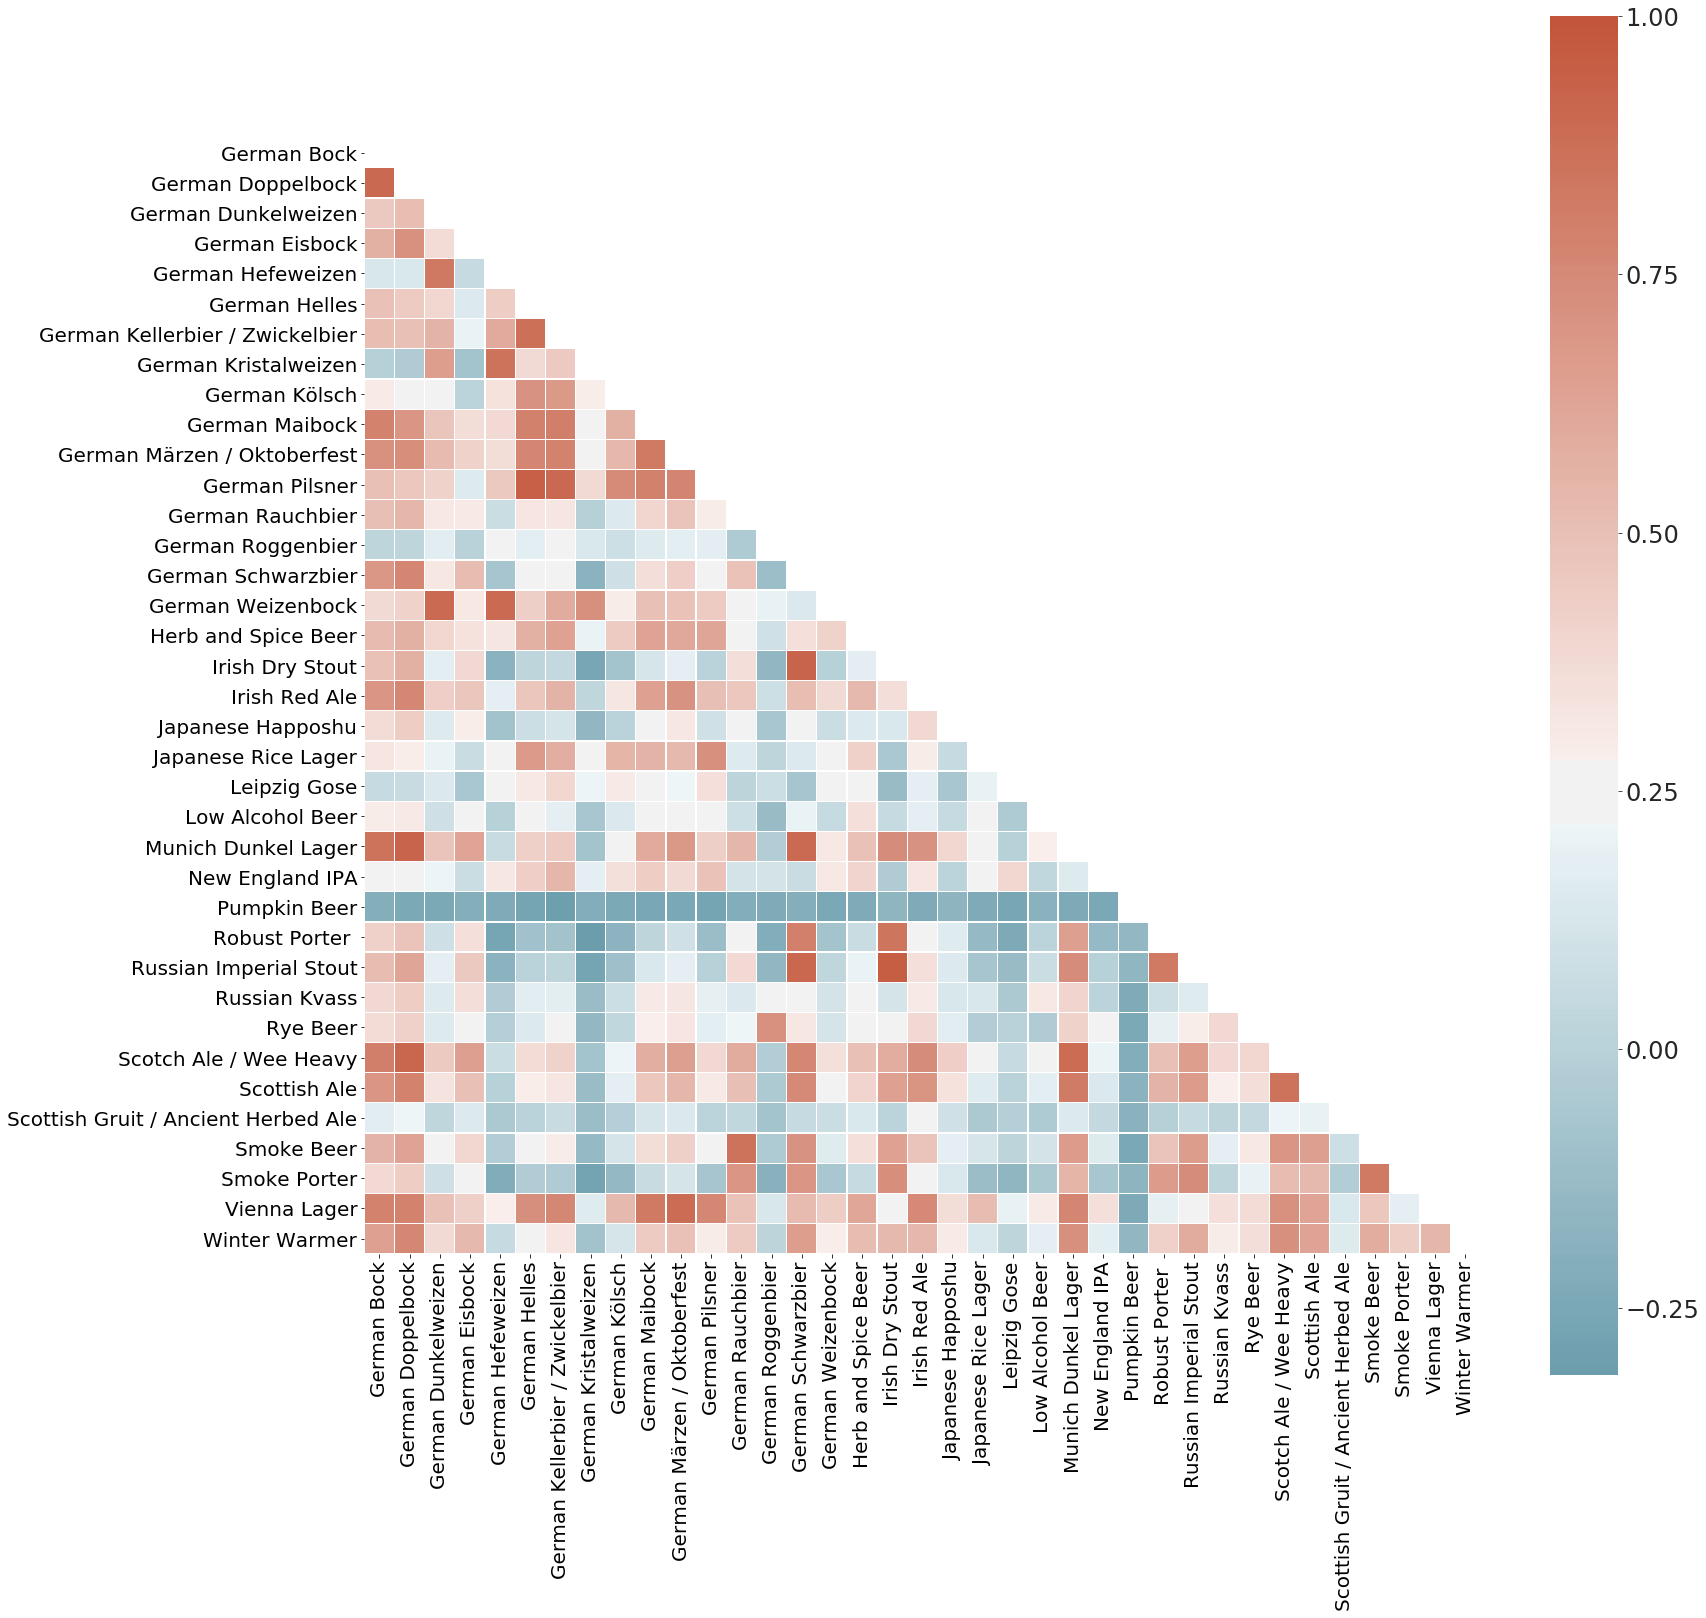

In [32]:
cos1 = X.dot(X.T)/(np.linalg.norm(X) * np.linalg.norm(X.T))
ind1 = 70
ind2 = 107
df = pd.DataFrame(cos1[ind1:ind2, ind1:ind2])
corr1 = df.corr()

#Generate a mask for the upper triangle
mask = np.zeros_like(corr1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

#Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

#Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, sep=10, as_cmap=True)
sns.set_style("whitegrid")

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr1, mask=mask, vmax=1.0, center=0.25, cmap=cmap,
            square=True, linewidths=.25, xticklabels= False)
ticks1 = list(range(df.shape[1]))
ticks1 = np.array(ticks1)
ticks1 = ticks1 + 0.5
plt.xticks(ticks1, grp1['drink_type'][ind1:ind2], fontsize=20, rotation=90)
plt.yticks(ticks1, grp1['drink_type'][ind1:ind2], fontsize=20, rotation = 0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=24)

Pumpkin beers are really weird! They have essentially no similarity to other beers. We can also see that the German Kristalweizen, which is a kind of sparkling wheat beer, is also quite different to other beers. 

Let's do this for some other subset of beers. How about the first 50 beers? This includes a lot of American beers. We can try another style to visualise the correlation instead of the triangle, which this time we will output in the square matrix style. 

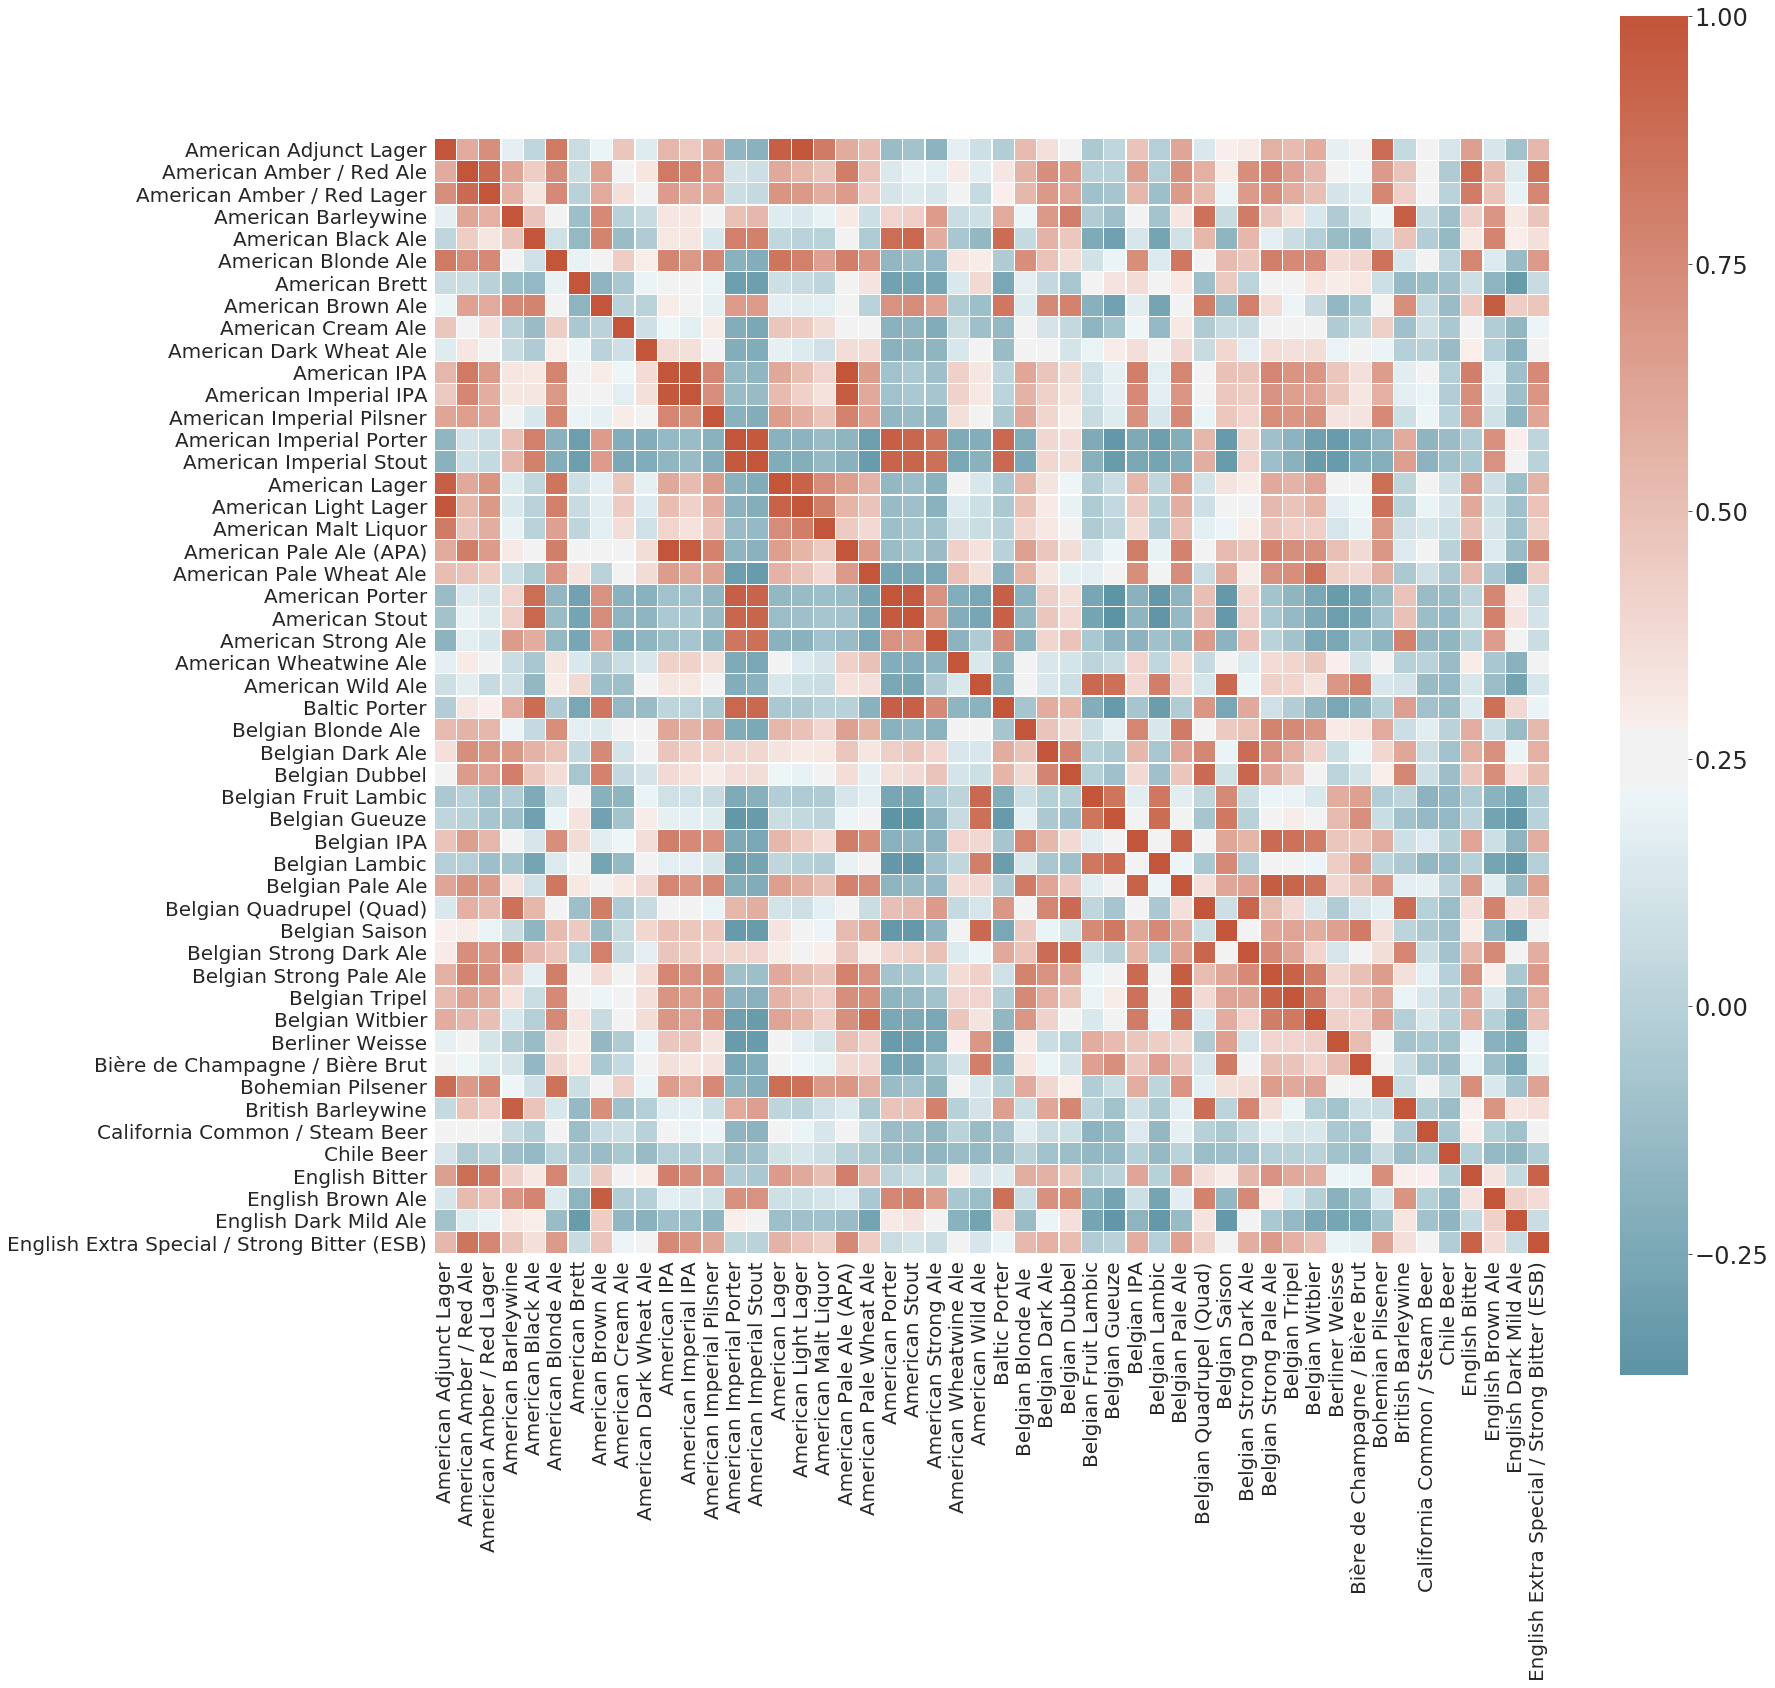

In [33]:
ind1 = 0
ind2 = 50
df = pd.DataFrame(cos1[ind1:ind2, ind1:ind2])
corr1 = df.corr()

#Generate a mask for the upper triangle
mask = np.zeros_like(corr1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False


#Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

#Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, sep=10, as_cmap=True)
sns.set_style("whitegrid")

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr1, mask=mask, vmax=1.0, center=0.25, cmap=cmap,
            square=True, linewidths=.25, xticklabels= False)
ticks1 = list(range(df.shape[1]))
ticks1 = np.array(ticks1)
ticks1 = ticks1 + 0.5
plt.xticks(ticks1, grp1['drink_type'][ind1:ind2], fontsize=20, rotation=90)
plt.yticks(ticks1, grp1['drink_type'][ind1:ind2], fontsize=20, rotation = 0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=24)

Porters and stouts seem to be very different from other beers! This makes sense, as anyone who has had these beers will probably know this to be true. We can also see that the Chilean Beer is very different to the others, the Belgian beers are similar to each other as expected, and the American IPAs and Pilsners seem to be close to each other.

It would be interesting to see if we can group beer styles together now that we can see that some beers are more similar to others while some others are very dissimilar. How about a clustering plot?

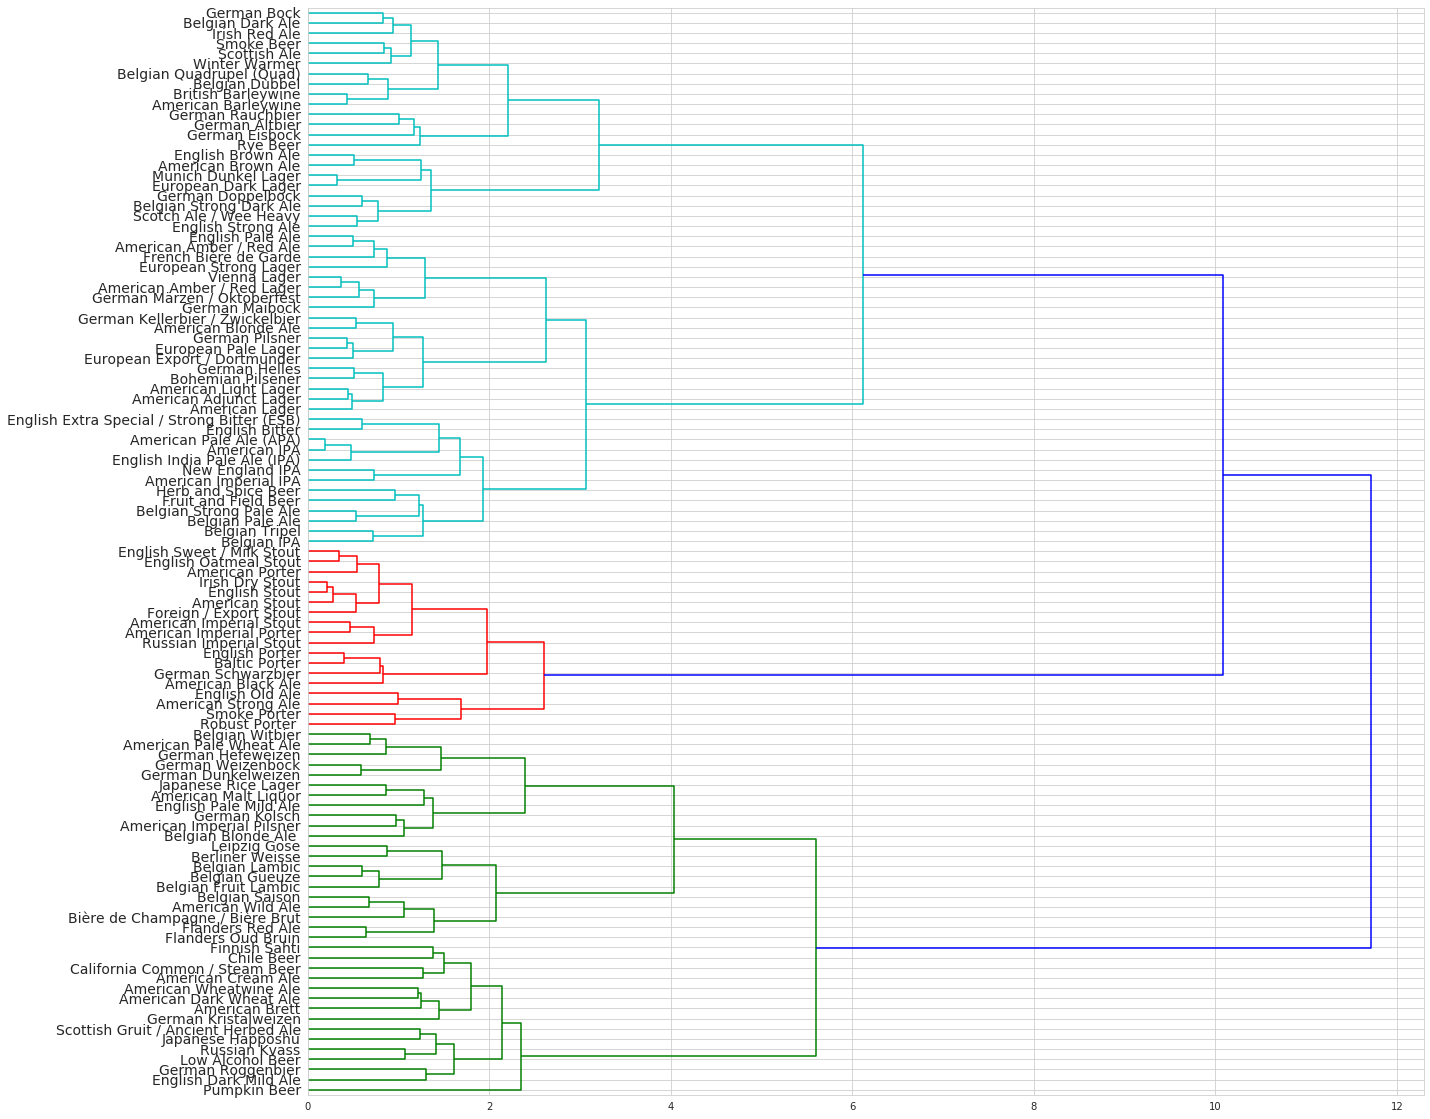

In [34]:
## Can we see how many groupings there are?
dist = 1 - cosine_similarity(X)
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances
fig, ax = plt.subplots(figsize=(20, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels = list(grp1['drink_type']));
plt.yticks(fontsize=14)
plt.rcParams.update(plt.rcParamsDefault)



Interesting! There seem to be many different beer styles. Pumpkin beer is so different that it is its own style of beer! On a broad level however there seem to be 3 styles visible corresponding to 3 colours on the plot. These are approximately grouped by:

    1 - Belgians, wheat ales, and some of the more different beers like the Chile Beer and the low alcohol beer 
    which at the very least resemble wheat beers more than they resemble strong ales or IPAs
    2 - Stouts and Porters (as we saw previously these are just really distinct) and some strong ales
    3 - IPAs, Pilsners and Lagers, and the brown and red ales


Let's label each of the beer types in our data above with a cluster label.



In [35]:
cluster_results = fcluster(linkage_matrix,3,criterion='maxclust')
for item in np.unique(cluster_results):
    print(np.sum(cluster_results==item))

36
18
53


As we can see, we have a lot more of cluster 3, that is the Pilsner, Lagers, and IPAs, and the least number of beer types is in the Porters, Stouts, and Strong Ales grouping.

Let's add the cluster labels to our data frame in order to have labels for when we build the model.

In [36]:
data2 = grp1.copy()
data2['cluster_labels'] = list(cluster_results)
data2.head()

,drink_type,reviews,cluster_labels
0,American Adjunct Lager,a ml brought back from by friends although it ...,3
1,American Amber / Red Ale,a the is clear red in color and has a amount o...,3
2,American Amber / Red Lager,bright amber lively thin yet lasting foamy the...,3
3,American Barleywine,medium to amber in color with a high degree of...,3
4,American Black Ale,pitch black with no visible only a hint of a c...,2


An interesting question from a prediction point of view now is, can we predict the beer style given it's review?
That is given the text of the review for a particular beer type, can we predict if the beer type in question falls into the grouping of IPAs, Pilsners, Lagers or in the grouping of Stouts and Porters or is a Belgian, wheat beer?

Let's split our 107 rows of data into train and test data. 

In [37]:
train_data, test_data = sklearn.model_selection.train_test_split(data2, test_size= 0.20)
train_data.head()

,drink_type,reviews,cluster_labels
56,English Stout,deep black color with a thick beige nitro with...,2
96,Robust Porter,charcoal brown with minimal malty nose with a ...,2
85,German Weizenbock,opaque treacle with ruby hues modest beige fal...,1
53,English Pale Ale,brazilian of a somewhat transparent and somewh...,3
34,Belgian Quadrupel (Quad),date appearance murky brown with a hint of rub...,3


In [0]:
vectorizer = TfidfVectorizer(stop_words='english', max_features = 5000)
X2 = vectorizer.fit_transform(train_data['reviews'])   #tfidf matrix for train data reviews
X3 = vectorizer.fit_transform(test_data['reviews'])    #tfidf matrix for test data reviews

We will use the KNeighbors Classifier to predict the grouping label. Our input data is the tfidf matrix for the reviews and our output is the cluster label. We want to maximise accuracy in the sense of accurately predicting the cluster labels that were assigned through the hierarchical clustering algorithm shown earlier. For more information on the KNeighbors Classifier see [here](https://scikit-learn.org/stable/modules/neighbors.html#classification).

In [39]:
n_neighbors = 3
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
clf.fit(X2, train_data['cluster_labels'])
c2 = clf.predict(X3)
test_data.loc[:, 'predictions'] = list(c2)
accuracy = (test_data['cluster_labels'] == test_data['predictions']).sum() / len(test_data['cluster_labels'])
print(accuracy)

0.5


Around 50% accuracy, not so great! Luckily, this is still better than 1/3 though which would be what we would have with random guessing.


#Interactive Plots
---
Throughout our exploration, we created some beautiful visualizations that we just wanted to share. Below is a beautiful, interactive map that shows the average beer rating by country. 


In [40]:
def generate_csv(file_name, df):
      with open(file_name, mode='w') as f:
        csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

        csv_writer.writerow(['COUNTRY', 'AVG RATING', 'CODE'])

        country_grouped = df.groupby('country')
        for country in country_grouped.groups.keys():
            total = 0
            count = 0
            for rating in country_grouped.get_group(country)['avg_rating']:
                total = total + float(rating)
                count = count + 1

            csv_writer.writerow([iso3166.countries_by_alpha2[country.upper()][0], total/count, iso3166.countries_by_alpha2[country.upper()][2]])
        
def plot_interactive_map(csv_data_file):
    df = pd.read_csv(csv_data_file)

    fig = go.Figure(data=go.Choropleth(
        locations = df['CODE'],
        z = df['AVG RATING'],
        text = df['COUNTRY'],
        colorscale = 'Reds',
        autocolorscale=False,
        reversescale=False,
        marker_line_color='darkgray',
        marker_line_width=0.5,
        colorbar_title = 'Average rating',
    ))

    fig.update_layout(
        title_text='Which country produces the best beers in the world?',
        geo=dict(
            showframe=False,
            showcountries=True,
            showcoastlines=True,
            projection_type='orthographic'
        ),
        annotations = [dict(
            x=0.55,
            y=0.1,
            xref='paper',
            yref='paper',
            text="",
            showarrow = False
        )]
    )

    fig.show(renderer="notebook_connected")
beer_data = dataset.copy()
generate_csv('country_avg_ratings.csv', beer_data)
plot_interactive_map('country_avg_ratings.csv')

Here is another interactive plot of the various breweries in the United States, where each color represents a different type of brewery. Feel free to zoom in and find your favorite brewery, although we only plot the first 1000 breweries rather than all of them in order to avoid our visualization taking too long to load. We tend to enjoy Hofbrauhaus in Pittsburgh.

The colors are as follows:


*   Red is a microbrewery
*   Blue is a regional pub
*   Black is a brewpub
*   Green is a contract brewery
*   Orange is a propreitor
*   Grey is a large brewery
*   Pink is a bar
*   White is a planning brewery

Make sure you don't miss the icons for each brewery!


In [41]:
brewery_copy=openbrew_df.copy()
brewery_copy=brewery_copy.dropna()
origin_locations=brewery_copy[['latitude','longitude']]
#39.8283,-98.5795 are the coordinates for the geographical center of the USA
origin_locations=origin_locations.values.tolist()
types=brewery_copy["brewery_type"].tolist()
names=brewery_copy["name"].tolist()
colors=[]
for i in range(len(types)):
  type1=types[i]
  if type1=='micro':
    colors.append('red')
  elif type1 == 'regional':
    colors.append('blue')
  elif type1 == 'brewpub':
    colors.append('black')
  elif type1 == 'contract':
    colors.append('green')
  elif type1 == 'proprietor':
    colors.append('orange')
  elif type1 == 'large':
    colors.append('grey')
  elif type1 == 'bar':
    colors.append('pink')
  elif type1 == 'planning':
    colors.append('white')
def USAMap(default_location=[39.8283,-98.5795], default_zoom=5):
  usa_map = folium.Map(location=default_location,control_scale=True,zoom_start=default_zoom) #USAmap 
  return usa_map
starter_map = USAMap()

marker_cluster = folium.plugins.MarkerCluster().add_to(starter_map)
for i in range(1000):
  folium.Marker(origin_locations[i], popup=names[i]+'\n' + 'Type:' + types[i], icon=folium.Icon(color=colors[i], icon='beer', prefix = 'fa')).add_to(marker_cluster)
starter_map


# Conclusion
---

We see that we can draw a few conclusions from this overall exploration. The first, while somewhat obvious, is that predicting which beers will be highly rated is a difficult task. Although, these ratings are heavily correlated with both ABV and IBU values. We also found out which words are often used to describe each beer, as well as find out which beers are heavily correlated with each other. Finally, we found some interesting interactive plots that are fun to play with.

# Interested? Learn More
---

*   [How to use data science to brew beer](https://datascience.virginia.edu/pages/using-data-science-brew-beer)
*   [How big data helps bar owners sell beer](https://datafloq.com/read/big-data-helps-bar-owners-sell-beer/250)
*   [Big Data Meets the Beer Industry](https://fortune.com/2019/01/29/iot-big-data-beer-industry/)
*   [A USAToday survey of the most popular US beer brands](https://www.usatoday.com/story/money/food/2018/05/03/most-popular-us-beer-brands/573703002/)

